# Exok behaviour with an ocean at the surface

This code is only a test and Exok was used without ocean and without water in the atmosphere in the coupling. Actually it gives a really higher waper vapor concentration in the atmosphere than the GCM, and the surface temperature becomes unrealistic.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import exo_k as xk

# --- ATMOSPHERIC PARAMETERS ---
fH2 = 0.15
fCO2 = 0.84
fCH4 = 0.0
fN2 = 1 - fCH4 - fCO2 - fH2

Psurf = 2e5
Ptop = 1
Tsurf = 300
grav = 3.71

    
composition = {
    'H2': fH2,
    'CO2': fCO2,
    'CH4': fCH4,
    'N2': 'background' 
}

composition2 = {
    'H2': fH2,
    'CO2': fCO2,
    'CH4': fCH4,
    'N2': 'background' 
}

In [2]:
# --- OPACITIES ---

datapath_ktables = 'Ktables/'
datapath_ciatables = 'ciatables/'
xk.Settings().set_mks(True)
xk.Settings().set_search_path(datapath_ktables, path_type='ktable')
xk.Settings().set_search_path(datapath_ciatables, path_type='cia')

k_db = xk.Kdatabase(['CO2', 'CH4', 'H2O'], '')


Res = 10
wn_grid = xk.wavenumber_grid_R(40., 25000., Res)

k_db_LR = k_db.bin_down_cp(wnedges=wn_grid, remove_zeros=True)
cia_db_LR = xk.CIAdatabase(molecules=['H2','CO2','CH4','H2O','N2'], mks=True)
cia_db_LR.sample(k_db_LR.wns)

Careful, not all tables have the same wavelength grid.
                        You'll need to use bin_down (Ktable) or sample (Xtable)
Careful, not all tables have the same wavelength grid.
                        You'll need to use bin_down (Ktable) or sample (Xtable)
Careful, not all tables have the same wavelength grid.
                        You'll need to use bin_down (Ktable) or sample (Xtable)
Careful, not all tables have the same wavelength grid.
                        You'll need to use bin_down (Ktable) or sample (Xtable)


In [3]:
# --- USEFUL FUNCTIONS ---

def compute_R_over_cp(fN2, fCO2, fCH4, fH2):
    """
    Calcule R/cp pour un melange gazeux donne par les fractions molaires.
    Arguments:
        fN2, fCO2, fCH4, fH2 : fractions molaires de N2, CO2, CH4 et H2
    Retourne:
        R/cp (sans dimension)
    """

    # Verifier que la somme des fractions est proche de 1
    total_fraction = fN2 + fCO2 + fCH4 + fH2
    if abs(total_fraction - 1.0) > 1e-6:
        raise ValueError("La somme des fractions molaires doit etre egale a 1.")

    # Valeurs de gamma pour chaque gaz
    gamma_N2 = 1.4
    gamma_CO2 = 1.3
    gamma_CH4 = 1.32
    gamma_H2 = 1.41

    # Calcul de R/cp pour chaque gaz
    Rcp_N2 = 1 - 1 / gamma_N2
    Rcp_CO2 = 1 - 1 / gamma_CO2
    Rcp_CH4 = 1 - 1 / gamma_CH4
    Rcp_H2 = 1 - 1 / gamma_H2

    # Moyenne ponderee
    Rcp_total = (fN2 * Rcp_N2 +
                 fCO2 * Rcp_CO2 +
                 fCH4 * Rcp_CH4 +
                 fH2 * Rcp_H2)

    return Rcp_total

def equilibrium_state_values(model):
    time_evo = model.time_hist / xk.DAY
    teq = time_evo[-1]
    T = model.tlay_hist[:, -1]
    mask = np.where(time_evo > teq/2)
    T = T[mask]
    last_T_profile = model.tlay_hist[-1,:]
    last_P_profile = model.atm.play
    return teq,np.mean(T),last_T_profile,last_P_profile

In [4]:
# --- DEFINING ATMOSPHERES ---

tracers = {
    'H2O': {'type': 'vapor', 'condensed_form': 'H2O_liq'},
    'H2O_liq': {'surface_reservoir': np.inf}
}

condensing_species = {
        'H2O': {
                'Latent_heat_vaporization': 2.086e6,  # Latent heat at ref temperature (J/kg)
                'cp_vap'                  : 4.228e3,  # Specific heat of the vapor (J/kg/K)
                'Mvap'                    : 18.e-3,  # Molar mass of the vapor
                'T_ref'                   : 273.,  # Reference temperature
                'Psat_ref'                : 612.,  # Saturation pressure at reference temperature
                }}

evol = xk.Atm_evolution(
    psurf=Psurf,
    ptop=Ptop,
    Tsurf=Tsurf,
    Tstrat=100,
    grav=3.71,
    rcp=compute_R_over_cp(fN2, fCO2, fCH4, fH2),
    albedo_surf=0.161,
    bg_vmr=composition,
    tracers=tracers,
    Nlay=50,
    k_database=k_db_LR,
    cia_database=cia_db_LR,
    rayleigh=True,
    flux_top_dw=109, 
    condensing_species=condensing_species,
    Tstar = 5778,
    condensation=True,
    moist_convection=True, 
    moist_inhibition=True,
    convection=True,
    diffusion=True,
    rain=True,
    acceleration_mode=0,
    mass_redistribution=False
    
)

evol2 = xk.Atm_evolution(
    psurf=Psurf,
    ptop=Ptop,
    Tsurf=Tsurf,
    Tstrat=100,
    grav=3.71,
    rcp=compute_R_over_cp(fN2, fCO2, fCH4, fH2),
    albedo_surf=0.161,
    bg_vmr=composition2,
#     tracers=tracers,
    Nlay=50,
    k_database=k_db_LR,
    cia_database=cia_db_LR,
    rayleigh=True,
    flux_top_dw=109, 
#     condensing_species=condensing_species,
    Tstar = 5778,
    convection=True,
    diffusion=True,
    
)

In [5]:
# --- EQUILIBRATING ATMOPSHERES ---
from IPython.utils import io
with io.capture_output() as _:
    evol.equilibrate(Fnet_tolerance=0.01)
    evol2.equilibrate(Fnet_tolerance=0.01)# tol = critère de convergence en W/m²
teq,Teq,T_profile,P_profile = equilibrium_state_values(evol)
teq2,Teq2,T_profile2,P_profile2 = equilibrium_state_values(evol2)


319.95989134094657 320.958516732655
305.83806472456746 305.83809549107644


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


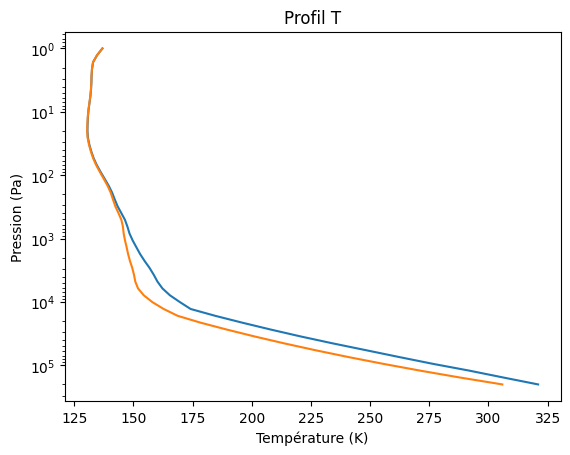

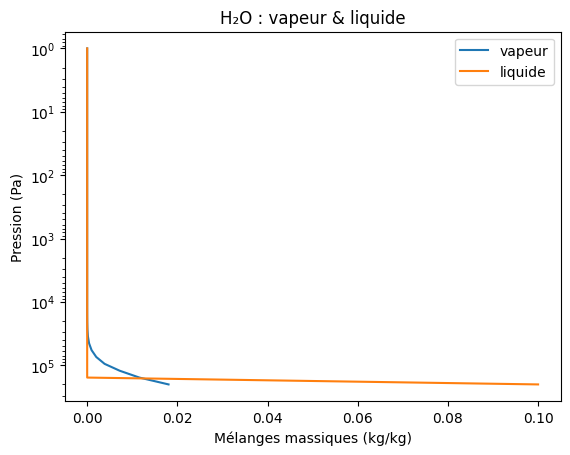

In [6]:
# --- PLOTTING ---
atm = evol.atm
p = evol.atm.play
T = evol.atm.tlay

atm2 = evol2.atm
p2 = evol2.atm.play
T2 = evol2.atm.tlay

qv = evol.tracers['H2O']
ql = evol.tracers['H2O_liq']

plt.figure()
plt.plot(T, p)
plt.plot(T2, p2)
plt.gca().invert_yaxis()
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.yscale('log')
plt.title('Profile T')

plt.figure()
plt.plot(qv, p, label='vapor')
plt.plot(ql, p, label='liquid')
plt.gca().invert_yaxis()
plt.xlabel('Mass mixings (kg/kg)')
plt.ylabel('Pressure (Pa)')
plt.title('H₂O : vapor & liquid')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [7]:
def plot_evolution(model, figsize=(6, 6), write=False):
    """A small routine to make standard plots of the evolution.
    It returns the figure and axis objects.
    Customize at will.
    """
    time_evo = model.time_hist / xk.DAY
    if write:
        print('evol_time (days):', time_evo[-1])
        print('last timestep:', (time_evo[-1] - time_evo[-2]), 'day')
        print('Number of steps since last kernel computation:', model.N_last_ker)
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=figsize)
    axs[0].plot(time_evo, model.Fnet_top, label='Top of Atmosphere')
    axs[0].plot(time_evo, np.ones_like(model.Fnet_top) * model.atm.internal_flux,
                label='internal flux')
    axs[1].plot(time_evo, model.tlay_hist[:, -1], label='internal flux')
    axs[0].set_ylabel(r'Net Flux')
    axs[1].set_ylabel(r'$T_{surf}$')
    axs[1].set_xlabel(r'Time (days)')
    axs[0].legend()
    fig.tight_layout()
    return fig,axs



evol_time (days): 19323.05896002455
last timestep: 0.37739637153208605 day
Number of steps since last kernel computation: 1200
evol_time (days): 2415.9641097724266
last timestep: 0.3775167022613459 day
Number of steps since last kernel computation: 6400


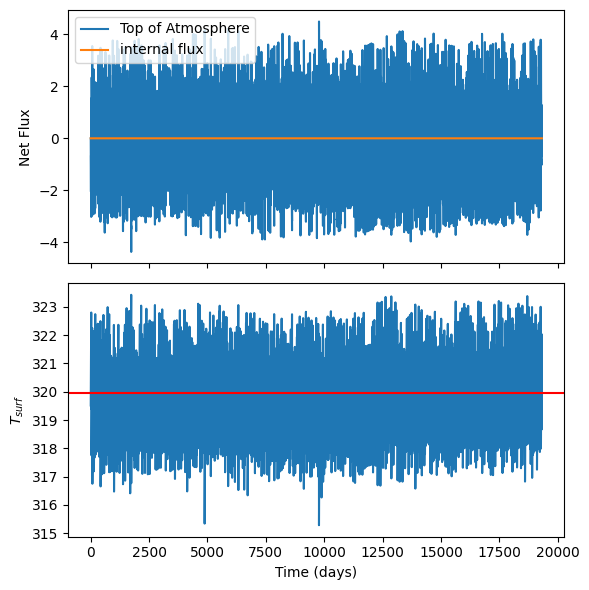

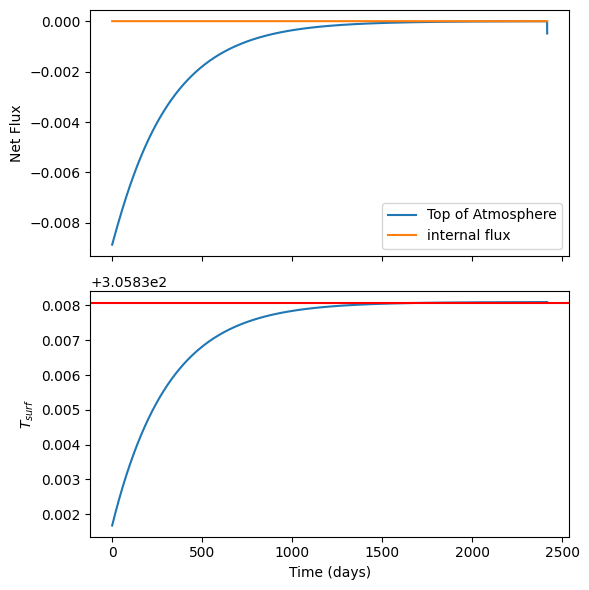

In [8]:
fig,axs= plot_evolution(evol, write=True)
axs[1].axhline(y=Teq,c='r')
fig2,axs2= plot_evolution(evol2, write=True)
axs2[1].axhline(y=Teq2,c='r')